In [80]:
import sys, os, re
from typing import *
sys.path = (["../src/", "../"] if re.match(r"^(\w\:\\)|(/)", os.getcwd()) else []) + sys.path
import qubx
%qubxd dev 

%load_ext autoreload
%autoreload 2

from qubx import lookup, logger
from qubx.core.basics import Subtype, Instrument, Signal
from qubx.core.interfaces import IStrategy, IStrategyContext, TriggerEvent
from qubx.core.metrics import tearsheet, chart_signals
from qubx.pandaz.utils import *
import qubx.ta.indicators as ta

# - - - - - - - - - - - - - - - - - - - - - - - -
from qubx.data.helpers import loader
from qubx.backtester.simulator import simulate

ld = loader("BINANCE.UM", "1h", source="csv::../tests/data/csv_1h", n_jobs=1)

 >  [dev] installing cython rebuilding hook


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Current approach 

In [4]:
class TestA(IStrategy):
    """ Document your strategy here """
    timeframe: str = "15Min"
    exchange = 'BINANCE.UM'

    def on_init(self, ctx: IStrategyContext):
        ctx.set_base_subscription(Subtype.OHLC[self.timeframe])
        ctx.set_event_schedule("55 23 * * *")
        ctx.set_fit_schedule("50 23 * * 1")
        self._idx = 0
        self._to_test = [
            [self.find_instrument(s) for s in ["BTCUSDT", "ETHUSDT"]],
            [self.find_instrument(s) for s in ["BTCUSDT", "BCHUSDT", "LTCUSDT"]],
            [self.find_instrument(s) for s in ["BTCUSDT", "AAVEUSDT", "ETHUSDT"]],
            [self.find_instrument(s) for s in ["BCHUSDT"]],
        ]

    def on_fit(self, ctx: IStrategyContext):
        logger.info(f" -> subscribe : {self.lst(self._to_test[self._idx])}")
        ctx.set_universe(self._to_test[self._idx])
        self._idx += 1
        if self._idx >= len(self._to_test):
            self._idx = 0 

    def on_event(self, ctx: IStrategyContext, event: TriggerEvent) -> Optional[List[Signal]]:
        s = []
        logger.info(f"Trig: {self.lst(ctx.instruments)} --> {str({i.symbol: ctx.quote(i) for i in ctx.instruments})}")
        if 1:
            for i in ctx.instruments:
                data = ctx.ohlc(i, self.timeframe)
                s1 = ta.kama(data.close, 36) - ta.kama(data.close, 12)
                if len(s1) > 1:
                    if s1[1] < 0 and s1[0] > 0:
                        logger.info(f"BUY: {i}")
                        s.append(ctx.instruments[0].signal(+1))

                    if s1[1] > 0 and s1[0] < 0:
                        logger.info(f"SELL: {i}")
                        s.append(i.signal(-1))
        return s

    def find_instrument(self, symbol: str) -> Instrument:
        return lookup.find_symbol(self.exchange, symbol) # type: ignore

    def lst(self, instrs: list[Instrument]):
        return ','.join(map(lambda x: x.symbol, instrs))


In [5]:
r = simulate(
   # {'A': TestA(timeframe="1h")}, ld, 1000, 
   variate(TestA, timeframe=["15Min", "30Min", "1h"]), ld, 1000, 
   ['BINANCE.UM:BTCUSDT'],
   "vip0_usdt", "2023-07-01", "2023-07-30", debug="DEBUG"
)

2023-07-02 00:59:59.000 [🐞] TestA new parameters:
	set timeframe <- 15Min
2023-07-02 00:59:59.000 [🐞] TestA new parameters:
	set timeframe <- 30Min
2023-07-02 00:59:59.000 [🐞] TestA new parameters:
	set timeframe <- 1h


  0%|          | 0/3 [00:00<?, ?it/s]

2024-12-09 15:45:00.954 [ 🐞 ] (simulator) 2023-07-01 00:00:00 Initiating simulated trading for binance.um for 1000 x 1.0 in USDT...
2023-07-01 00:00:00.000 [ℹ️] SimulatedExchange.binance.um is initialized


Simulating:   0%|          | 0/100 [00:00<?, ?%/s]

2023-07-01 00:00:00.000 [🐞]  | get_subscribed_instruments __all__ -> []
2023-07-01 00:00:00.000 [🐞]  | get_subscriptions None -> []
2023-07-01 00:00:00.000 [🐞]  | get_subscribed_instruments ohlc(15Min) -> []
2023-07-01 00:00:00.000 [🐞]  | get_subscribed_instruments None -> []
2023-07-01 00:00:00.000 [🐞]  | get_subscribed_instruments ohlc(15Min) -> []
2023-07-01 00:00:00.000 [🐞]  | subscribe: ohlc(15Min) -> {BINANCE.UM:SWAP:BTCUSDT}
2023-07-01 00:00:00.000 [ℹ️] SimulatedExchange ::: Simulation started at 2023-07-01 :::
2023-07-01 00:00:00.000 [🐞] Preloading initial data for ohlc.15Min 2023-07-01 00:00:00 : 2023-07-30 00:00:00 ...
2023-07-01 00:00:00.000 [🐞] (InMemoryCachedReader) Updating 1 symbols post interval 2023-07-02 00:00:00 : 2023-07-30 00:00:00
2023-07-01 00:00:01.000 [🐞] Invoking TestA on_fit
2023-07-01 00:00:01.000 [ℹ️]  -> subscribe : BTCUSDT,ETHUSDT
2023-07-01 00:00:01.000 [🐞]  | get_subscribed_instruments __all__ -> [BINANCE.UM:SWAP:BTCUSDT]
2023-07-01 00:00:01.000 [🐞]  | 

Simulating:   0%|          | 0/100 [00:00<?, ?%/s]

2023-07-01 00:00:00.000 [🐞]  | get_subscriptions None -> []
2023-07-01 00:00:00.000 [🐞]  | get_subscribed_instruments ohlc(30Min) -> []
2023-07-01 00:00:00.000 [🐞]  | get_subscribed_instruments None -> []
2023-07-01 00:00:00.000 [🐞]  | get_subscribed_instruments ohlc(30Min) -> []
2023-07-01 00:00:00.000 [🐞]  | subscribe: ohlc(30Min) -> {BINANCE.UM:SWAP:BTCUSDT}
2023-07-01 00:00:00.000 [ℹ️] SimulatedExchange ::: Simulation started at 2023-07-01 :::
2023-07-01 00:00:00.000 [🐞] Preloading initial data for ohlc.30Min 2023-07-01 00:00:00 : 2023-07-30 00:00:00 ...
2023-07-01 00:00:01.000 [🐞] Invoking TestA on_fit
2023-07-01 00:00:01.000 [ℹ️]  -> subscribe : BTCUSDT,ETHUSDT
2023-07-01 00:00:01.000 [🐞]  | get_subscribed_instruments __all__ -> [BINANCE.UM:SWAP:BTCUSDT]
2023-07-01 00:00:01.000 [🐞]  | get_subscriptions None -> ['ohlc(30Min)']
2023-07-01 00:00:01.000 [🐞]  | get_subscribed_instruments ohlc(30Min) -> [BINANCE.UM:SWAP:BTCUSDT]
2023-07-01 00:00:01.000 [🐞]  | get_subscribed_instruments

Simulating:   0%|          | 0/100 [00:00<?, ?%/s]

2023-07-01 00:00:00.000 [🐞]  | get_subscribed_instruments None -> []
2023-07-01 00:00:00.000 [🐞]  | get_subscribed_instruments ohlc(1h) -> []
2023-07-01 00:00:00.000 [🐞]  | subscribe: ohlc(1h) -> {BINANCE.UM:SWAP:BTCUSDT}
2023-07-01 00:00:00.000 [ℹ️] SimulatedExchange ::: Simulation started at 2023-07-01 :::
2023-07-01 00:00:00.000 [🐞] Preloading initial data for ohlc.1h 2023-07-01 00:00:00 : 2023-07-30 00:00:00 ...
2023-07-01 00:00:01.000 [🐞] Invoking TestA on_fit
2023-07-01 00:00:01.000 [ℹ️]  -> subscribe : BTCUSDT,ETHUSDT
2023-07-01 00:00:01.000 [🐞]  | get_subscribed_instruments __all__ -> [BINANCE.UM:SWAP:BTCUSDT]
2023-07-01 00:00:01.000 [🐞]  | get_subscriptions None -> ['ohlc(1h)']
2023-07-01 00:00:01.000 [🐞]  | get_subscribed_instruments ohlc(1h) -> [BINANCE.UM:SWAP:BTCUSDT]
2023-07-01 00:00:01.000 [🐞]  | get_subscribed_instruments None -> [BINANCE.UM:SWAP:BTCUSDT]
2023-07-01 00:00:01.000 [🐞]  | get_subscribed_instruments ohlc(1h) -> [BINANCE.UM:SWAP:BTCUSDT]
2023-07-01 00:00:01.

2023-07-30 00:59:59.000 [ℹ️] SimulatedExchange ::: Simulation finished at 2023-07-30 00:00:00 :::
2023-07-30 00:59:59.000 [🐞] TestB new parameters:
	set timeframe <- 1h


,,Gain,Cagr,Sharpe,Qr,Max dd pct,Mdd usd,Sortino,Calmar,Tail ratio,Stability,Var,Avg return,Fees,Execs
id,,,,,,,,,,,,,,,
0,TA_(t=15Min),-659.24220,-0.999998,3.041389,-0.574773,106.709664,2215.990000,14.924458,-1.114604,2.524995,0.291326,1328.670529,14.507123,30.51720,4.0
2,TA_(t=1h),-668.58825,-0.999999,3.020462,-0.590899,106.811806,2220.000000,14.826988,-1.114604,2.536118,0.305066,1330.357952,14.414770,30.68325,4.0
1,TA_(t=30Min),-27.31788,-0.286085,-3.623893,-0.144373,4.877510,48.775097,-4.355597,-10.472455,0.000000,0.193378,8.682623,-0.091148,1.94288,2.0


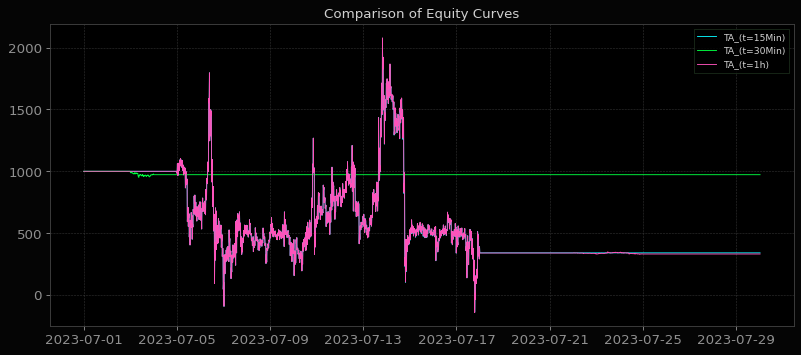

In [6]:
tearsheet(r, False, use_plotly=False)

In [7]:
r[2].config()

"TestA(timeframe='1h', exchange='BINANCE.UM')"

In [ ]:
# chart_signals(r[0], 'BTCUSDT', ld[['BTCUSDT']], show_signals=True)

### - What we want to have -

In [8]:
class TestB(IStrategy):
    timeframe: str = "15Min"

    def on_event(self, ctx: IStrategyContext, event: TriggerEvent) -> Optional[List[Signal]]:
        s = []
        logger.info('Event')
        if 0:
            for i in ctx.instruments:
                data = ctx.ohlc(i, self.timeframe)
                s1 = ta.kama(data.close, 36) - ta.kama(data.close, 12)
                if len(s1) > 1:
                    if s1[1] < 0 and s1[0] > 0:
                        logger.info(f" >> BUY: {i}")
                        s.append(ctx.instruments[0].signal(+1))

                    if s1[1] > 0 and s1[0] < 0:
                        logger.info(f"SELL: {i}")
                        s.append(i.signal(-1))
        return s

In [9]:
r = simulate(
   {'A': TestB(timeframe="1h")}, ld, 1000, 
   ['BINANCE.UM:BTCUSDT'],
   # "vip0_usdt", "2023-06-22", "2023-07-30", debug="DEBUG",
   "vip0_usdt", "2023-07-01", "2023-07-02", debug="DEBUG",

   accurate_stop_orders_execution=True,
   # simulation="ohlc(1h)",
   
)

2024-12-09 15:45:37.383 [ 🐞 ] (simulator) 2023-07-01 00:00:00 Initiating simulated trading for binance.um for 1000 x 1.0 in USDT...
2023-07-01 00:00:00.000 [ℹ️] SimulatedTrading emulates stop orders executions at exact price
2023-07-01 00:00:00.000 [ℹ️] SimulatedExchange.binance.um is initialized


Simulating:   0%|          | 0/100 [00:00<?, ?%/s]

2023-07-01 00:00:00.000 [🐞]  | get_subscribed_instruments __all__ -> []
2023-07-01 00:00:00.000 [🐞]  | get_subscriptions None -> []
2023-07-01 00:00:00.000 [🐞]  | get_subscribed_instruments ohlc(1Min) -> []
2023-07-01 00:00:00.000 [🐞]  | get_subscribed_instruments None -> []
2023-07-01 00:00:00.000 [🐞]  | get_subscribed_instruments ohlc(1Min) -> []
2023-07-01 00:00:00.000 [🐞]  | subscribe: ohlc(1Min) -> {BINANCE.UM:SWAP:BTCUSDT}
2023-07-01 00:00:00.000 [ℹ️] SimulatedExchange ::: Simulation started at 2023-07-01 :::
2023-07-01 00:00:00.000 [🐞] Preloading initial data for ohlc.1Min 2023-07-01 00:00:00 : 2023-07-02 00:00:00 ...
2023-07-01 00:00:01.000 [🐞] Invoking TestB on_fit
2023-07-01 00:00:01.000 [🐞] TestB is fitted
2023-07-01 00:24:00.000 [ℹ️] Event
2023-07-01 00:36:00.000 [ℹ️] Event
2023-07-01 00:59:59.000 [ℹ️] Event
2023-07-01 01:24:00.000 [ℹ️] Event
2023-07-01 01:36:00.000 [ℹ️] Event
2023-07-01 01:59:59.000 [ℹ️] Event
2023-07-01 02:24:00.000 [ℹ️] Event
2023-07-01 02:36:00.000 [ℹ️]

2023-07-01 22:59:59.000 [ℹ️] Event
2023-07-01 23:24:00.000 [ℹ️] Event
2023-07-01 23:36:00.000 [ℹ️] Event
2023-07-01 23:59:59.000 [ℹ️] Event
2023-07-02 00:24:00.000 [ℹ️] Event
2023-07-02 00:36:00.000 [ℹ️] Event
2023-07-02 00:59:59.000 [ℹ️] Event
2023-07-02 00:59:59.000 [ℹ️] SimulatedExchange ::: Simulation finished at 2023-07-02 00:00:00 :::
2023-07-02 00:59:59.000 [🐞] Connected to QuestDB at nebula:8812
2023-07-02 00:59:59.000 [🐞] Connected to QuestDB at nebula:8812
2023-07-02 00:59:59.000 [🐞] (InMemoryCachedReader) Loading all data 2023-07-01 00:00:00 - 2023-07-02 00:00:00 for BTCUSDT 
2023-07-02 00:59:59.000 [🐞] Connected to QuestDB at nebula:8812
2023-07-02 00:59:59.000 [🐞] Closing connection
2023-07-02 00:59:59.000 [🐞] (InMemoryCachedReader) Loading all data 2023-07-01 00:00:00 - 2023-07-02 00:00:00 for BTCUSDT 
2023-07-02 00:59:59.000 [🐞] Connected to QuestDB at nebula:8812
2023-07-02 00:59:59.000 [🐞] Closing connection
2023-07-02 00:59:59.000 [🐞] (InMemoryCachedReader) Loading al

In [10]:
r[0].config()

"TestB(timeframe='1h')"

In [ ]:
simulate.configs.ON_CLOSE()

In [ ]:
tearsheet(r, False)

In [ ]:
chart_signals(r[0], 'BTCUSDT', ld[['BTCUSDT']], show_signals=True)

### Data Recognition

In [100]:
data = ld[['BTCUSDT', 'ETHUSDT'], '2023-07-01':'2023-07-02']

In [ ]:
def _has_columns(v: pd.DataFrame, columns: list[str]):
    return all([c in v.columns for c in columns])

_types = {}
for k, v in data.items():

    if type(v) is pd.DataFrame:
        if _has_columns(v, ["open", "high", "low", "close"]):
            _types[k] = "OHLC"

        if _has_columns(v, ["bid", "ask"]):
            _types[k] = "QUOTES"

        if _has_columns(v, ["price", "size"]):
            _types[k] = "TRADES"
_types

{'BTCUSDT': 'OHLC', 'ETHUSDT': 'OHLC'}

In [ ]:
# l2 = loader("BINANCE.UM", "1h", source="csv::../tests/data/csv", n_jobs=1)
# l2 = loader("csv", "1h", source="csv::../tests/data/", n_jobs=1)

In [108]:
# l2.read("ETHUSDT", "2023-07-01", "2023-07-02", data_type="agg_trades", timeframe=None)
ld.read("BINANCE.UM:BTCUSDT", "2023-07-01", "2023-07-02", timeframe=None)

[array([Timestamp('2023-07-01 00:00:00'), 30459.1, 98338, 30527.2, 30405.6, 30460.2, 267887520.0, 130112864.0, 4269.25, 8790.093], dtype=object),
 array([Timestamp('2023-07-01 01:00:00'), 30433.4, 93651, 30475.7, 30367.4, 30459.1, 261595424.0, 117457504.0, 3860.466, 8597.762], dtype=object),
 array([Timestamp('2023-07-01 02:00:00'), 30408.4, 83641, 30522.0, 30380.0, 30433.3, 229735088.0, 110459080.0, 3627.463, 7545.346], dtype=object),
 array([Timestamp('2023-07-01 03:00:00'), 30391.2, 61442, 30435.7, 30362.0, 30408.4, 147269552.0, 70929880.0, 2333.582, 4845.068], dtype=object),
 array([Timestamp('2023-07-01 04:00:00'), 30381.4, 88569, 30412.3, 30311.3, 30391.2, 266895504.0, 128709680.0, 4239.098, 8790.924], dtype=object),
 array([Timestamp('2023-07-01 05:00:00'), 30415.2, 46344, 30423.4, 30381.3, 30381.3, 96719576.0, 56243364.0, 1850.019, 3181.499], dtype=object),
 array([Timestamp('2023-07-01 06:00:00'), 30441.5, 55250, 30462.8, 30387.6, 30415.3, 203003472.0, 114352240.0, 3758.18, 66

In [ ]:
# recognize_simulation_data()